<a href="https://colab.research.google.com/github/arash-am/Media-Competition/blob/main/Main/Complete_actions_Soft_DQN_finalize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # used for arrays
import gym # pull the environment
import time # to get the time
import math # needed for calculations
import torch
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')
from IPython.display import display, clear_output
from matplotlib.colors import LinearSegmentedColormap

Mounted at /content/gdrive


In [ ]:
class Opinon_w_media():
    def __init__(self, N=10**3, M=10, terminal_time=500,bM=5,b=25,noise_level=0.1,duration=50,nbins=10,h=0.01,r_scale=100):
        self.N = N
        self.M = M
        self.terminal_time = terminal_time
        Beta=torch.distributions.beta.Beta(3,2)
        self.s=Beta.sample(sample_shape=(N,))
        self.ym= torch.linspace(-1,1,steps=self.M)  # Uniformly distributed between -1 and 1
        self.noise_level = noise_level
        self.bM = bM
        self.b = b
        self.duration=duration
        self.action_dim=4
        self.nbins=nbins
        self.h=h
        self.pi=torch.tensor(np.pi)
        self.r_scale=r_scale

    def reset(self):
        self.state = torch.cat([torch.rand(self.N) * 2 - 1, 1*torch.ones(self.M), torch.tensor([0.])])
        return self.state

    def action_encoder(self,number):
        num_bits = int(self.M/2)
        binary_string = format(number, f'0{num_bits}b')
        action_vector = torch.tensor([float(bit) for bit in binary_string], dtype=torch.float32)
        return action_vector

    def action_decoder(self,action_vector):
        binary_string = ''.join(str(int(bit)) for bit in action_vector)
        number = int(binary_string, 2)
        return number

    def dyn_step(self,u_action_id, v_action_id):
      done=False
      state=self.state
      reward=0
      h=self.h
      gam=.98
      u_action=env.action_encoder(u_action_id)
      v_action=env.action_encoder(v_action_id)
      for i in range(self.duration):
            x, c, t = state[:self.N], state[self.N:-1], state[-1]
            DM  = self.ym - x[:, None]
            D   =  x - x[:, None]
            action = torch.cat([u_action, v_action])
            eta=1
            eta2=2
            AM = torch.exp(-self.bM * (1+eta*(action))*(1+eta2*(1-c)*(1-self.s.reshape(-1, 1))) * torch.abs(DM))
            A = torch.exp(-self.b  * torch.abs(D))
            t   += 1
            c= c*(gam)+action*(1-gam)
            x +=h*((torch.sum(A * D  , dim=1) / torch.sum(A, dim=1))+ (torch.sum(AM * DM  , dim=1) / torch.sum(AM  , dim=1)))+ torch.sqrt(h)*torch.normal(0, self.noise_level, size=(self.N,))
            state = torch.cat([x, c, t.unsqueeze(0)])
      self.state = state
      reward=self.r_scale*(-1*(torch.sin(self.pi*x/2)).pow(5)).mean()
      if t >= self.terminal_time:
            done = True
      return  reward, done

    def state2obs(self,state):
        xs=state[:self.N].clone().detach()
        cs=state[self.N:self.N+self.M].clone().detach()
        return torch.cat([1*torch.histc(xs, bins=self.nbins, min=-1, max=1)/self.N, cs])
        # return torch.cat([xs, cs])

    def step(self, u_action_id, v_action_id):
        reward, done=self.dyn_step(u_action_id, v_action_id)
        return self.state, reward, done, None
    def complet_action_space(self):
        action_space = torch.zeros((2**int(self.M/2),int(M/2)))
        for i in range(2**int(self.M/2)):
            action_space[i,:]=self.action_encoder(i)
        return action_space


    def plot_dist(self,x,c):
        cmap = plt.cm.coolwarm  # Choose blue-white-red colormap
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(self.ym,c,50,c=self.ym,cmap=cmap)
        plt.title('Credit Bias')
        plt.xlabel("Opinion-Bias")
        plt.ylabel("Credit Score")
        plt.xlim([-1.1 ,1.1])
        plt.ylim([0, 1])
        plt.grid(True)
        plt.subplot(1, 2, 2)
        plt.hist(x, np.linspace(-1.2,1.2,50), color='skyblue', edgecolor='black', alpha=0.3,density=True)
        plt.scatter(x,self.s,50,c=x,cmap=cmap,alpha=.1)
        plt.ylabel("Opinion")
        plt.xlabel("Frequency")
        plt.title("Distribution of Final Opinions")
        plt.grid(True)
        plt.xlim([-1.3,1.3])
        plt.tight_layout()
        plt.show()



import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import deque


class replay_buffer(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=self.capacity)

    def store(self, observation, action, reward, next_observation, done):
        observation = np.expand_dims(observation, 0)
        next_observation = np.expand_dims(next_observation, 0)
        self.memory.append([observation, action, reward, next_observation, done])

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        observations, actions, rewards, next_observations, dones = zip(* batch)
        return np.concatenate(observations, 0), actions, rewards, np.concatenate(next_observations, 0), dones

    def __len__(self):
        return len(self.memory)


class soft_q_net(nn.Module):
    def __init__(self, observation_dim,bpl,bop,M,action_dim=32):
        super(soft_q_net, self).__init__()
        self.observation_dim = observation_dim
        self.bpl = bpl
        self.bop = bop
        self.action_dim=action_dim
        self.M=M
        self.makspl=torch.zeros(action_dim,action_dim)
        self.maksop=torch.zeros(action_dim,action_dim)
        for i in range(action_dim):
            self.makspl[i,:]=i*action_dim+torch.arange(action_dim)
        for i in range(action_dim):
            self.maksop[i,:]=action_dim*torch.arange(action_dim)+i
                # Using The initialization & incorporating batch normalization
        self.fc1 = nn.Linear(self.observation_dim, 128)
        self.fc2 = nn.Linear(128, 512)
        self.fc3 = nn.Linear(512, self.action_dim**2)


    def forward(self, observation):
        x = self.fc1(observation)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

# Translate this to batchwise results -----------------------------------------------------------------------------
    def log_sum_exp(self,x):
        max_x=x.max(dim=1,keepdim=True)[0]
        exps = torch.exp(x - max_x)
        sum_of_exps = exps.sum(dim=-1)
        return torch.log(sum_of_exps) + max_x.squeeze()

    def getV(self, q_value):
        Q_pl=self.getQ_pl(q_value)
        v = (1/self.bpl) * (self.log_sum_exp(self.bpl * Q_pl)-torch.log(torch.tensor(self.action_dim)))
        return v


    # consider uniform policies
    def getQ_pl(self, q_value):
        Qa=torch.zeros((q_value.shape[0],self.action_dim,))
        for i in range(self.action_dim):
            x=self.bop*q_value[:,self.makspl[i,:].int()]
            Qa[:,i]=(1/self.bop)*(self.log_sum_exp(x)-torch.log(torch.tensor(self.action_dim)))
        Q_pl=Qa
        return    Q_pl


    def getQ_op(self, q_value):
        Qa=torch.zeros((q_value.shape[0],self.action_dim,))
        for i in range(self.action_dim):
            x=self.bpl*q_value[:,self.maksop[i,:].int()]
            Qa[:,i]=(1/self.bpl)*(self.log_sum_exp(x)-torch.log(torch.tensor(self.action_dim)))
            # Qa[:,i]=((self.bpl*q_value[:,self.maksop[i,:].int()].squeeze()).exp()).sum(dim=-1)/(self.action_dim)
        # Q_op = (1/self.bpl) * Qa.log()
        Q_op=Qa
        return    Q_op

# Correct the action spapce
    def act(self, observation):
        with torch.no_grad():
            # observation = torch.FloatTensor(np.expand_dims(obs, 0))
            q_value = self.forward(observation)
            Q_pl=self.getQ_pl(q_value)
            Q_op=self.getQ_op(q_value)
            pi_pl=F.softmax(self.bpl*Q_pl, dim=-1)
            pi_op=F.softmax(self.bop*Q_op, dim=-1)

            dist_pl = torch.distributions.Categorical(pi_pl)
            dist_op = torch.distributions.Categorical(pi_op)
            ac_pl=dist_pl.sample().item()
            ac_op=dist_op.sample().item()
            ac_id=ac_pl*self.action_dim+ac_op
        return ac_pl, ac_op,ac_id,torch.cat([pi_pl,pi_op])



def train(buffer, target_model, eval_model, gamma, optimizer, batch_size, loss_fn, count, update_freq,TAU):
      observation, action, reward, next_observation, done = buffer.sample(batch_size)
      observation = torch.FloatTensor(observation)
      action = torch.LongTensor(action)
      reward = torch.FloatTensor(reward)
      next_observation = torch.FloatTensor(next_observation)
      done = torch.FloatTensor(done)

      q_values = eval_model.forward(observation)
      next_q_values = target_net.forward(next_observation)
      next_v_values = target_net.getV(next_q_values)
      q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
      expected_q_value = reward + gamma * (1 - done) * next_v_values.squeeze(-1)
      loss = (expected_q_value.detach() - q_value).pow(2)
      loss = loss.mean()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # Soft update of the target network's weights
      # θ ← τ θ' + (1 −τ )θ′
      target_net_state_dict = target_model.state_dict()
      policy_net_state_dict = eval_model.state_dict()
      for key in policy_net_state_dict:
          target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
      target_model.load_state_dict(target_net_state_dict)
      with torch.no_grad():
        loss_p=((expected_q_value.detach() - q_value).pow(2).mean())
        loss_n=loss_p/q_value.var()
      return loss_p,loss_n,next_q_values






################ Parmeters #####################

N = 500
M=10
terminal_time=200
T_end=terminal_time
Duration=1
nbins=30
scale=100
env = Opinon_w_media(N=N, M=M, terminal_time = terminal_time,bM=5,b=20,noise_level=0.1,duration=Duration,h=torch.tensor(.1),nbins=nbins,r_scale=scale)
env.reset()

bins=np.linspace(-1,1,nbins)
min_loss = 5*10**4
gamma = 0.95
learning_rate = 1e-4
batch_size = 64
update_freq = batch_size*1
capacity = 1*10**5
render = False
episode = 2000000
observation_dim = nbins+M
bpl=10
bop=-10
TAU=0.002
action_dimension=2**int(M/2)
save_path='/content/gdrive/My Drive/UT/Data/complete_action_200_res'+str(M)+'_b'+str(bpl)+'_D'+str(Duration)
target_net = soft_q_net(observation_dim, bpl,bop,M,action_dimension )
eval_net = soft_q_net(observation_dim, bpl,bop,M,action_dimension )
avg_net = soft_q_net(observation_dim, bpl,bop,M,action_dimension )
eval_net.load_state_dict(target_net.state_dict())
# optimizer = torch.optim.Adam(eval_net.parameters(), lr=learning_rate,weight_decay=1e-2)
optimizer = torch.optim.Adam(eval_net.parameters(), lr=learning_rate,weight_decay=1e-3)
buffer = replay_buffer(capacity)
loss_fn = nn.MSELoss()
count = 0
reward_total = []
Loss=[]
R_t=0
loss_p=-1
epoch=0

################## The training loop

cmap = LinearSegmentedColormap.from_list("custom_blue_red", [(0, 0, 1), (1, 0, 0)], N=100)
# fig,ax=plt.subplots(1,2,figsize=(10,5))

C=[]
X=[]
Loss=[]
for i in range(episode):
    xct=env.reset()
    obs = env.state2obs(xct)
    if epoch>(40000-1):
        break
    while True:
        u_action, v_action,action_id,action_dist = eval_net.act(torch.FloatTensor(np.expand_dims(obs, 0)))
        count += 1
        n_xct, reward, Done, _  = env.step(u_action,v_action)
        x, c, t = n_xct[:N], n_xct[N:-1], n_xct[-1]
        next_obs = env.state2obs(n_xct)
        buffer.store(obs, action_id, reward, next_obs, Done)
        reward_total.append(reward)
        obs = next_obs
        if len(buffer.memory) > batch_size:
            if count % 50 == 0:
                epoch+=1
                loss_p,loss_n,q_print=train(buffer, target_net, eval_net, gamma, optimizer, batch_size, loss_fn, count, update_freq,TAU)
                Loss.append(loss_p)
                for key in eval_net.state_dict():
                      avg_net.state_dict()[key] = eval_net.state_dict()[key]/100 + avg_net.state_dict()[key]
                if epoch%100==0:
                    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                    # ax[0].scatter(x=np.array(X)[:].flatten(), y=np.repeat(env.s.squeeze(),np.array(X).shape[0]), c=np.array(X)[:].flatten(),s=1, cmap=cmap)
                    ax[0].scatter(x=np.array(X)[:].flatten(), y=np.repeat(env.s.squeeze(),np.array(X).shape[0]), c=np.array(X)[:].flatten(),s=.1, cmap=cmap,alpha=.5)
                    ax[0].set_ylim(0, 1)
                    ax[0].set_xlim(-1, 1)
                    ax[1].scatter(x=np.linspace(-1, 1, env.M), y=np.array(C).mean(axis=0), c=np.linspace(-1, 1, env.M), cmap=cmap)
                    ax[1].set_ylim(0, 1)
                    ax[1].set_xlim(-1, 1)
                    ax[2].semilogy(np.array(Loss))

                    clear_output(wait=True)  # Clear the output of the existing plot before redrawing
                    display(plt.gcf())  # Display the current figure
                    print(f'Epoch: {epoch}, \t Loss: {np.array(Loss).mean():.1e},\t Normal Loss: {loss_n:.1e}, \t count : {count:.1e}, \t Reward : {np.array(reward_total).mean():.1e}')
                    print(np.array(C).mean(axis=0))
                    reward_total=[]
                    avg_net.load_state_dict(eval_net.state_dict())
                    # Loss=[]
                    C=[]
                    X=[]
                    # save_filename = f'eval_net_min_loss.pt'  # Name the file indicating it's the best model so far
                    # torch.save(target_net.state_dict(), save_path + save_filename)
                    plt.close(fig)  # Close the figure to free resource
        if Done:
            C.append(c)
            X.append(x)
            break







test_net=soft_q_net(observation_dim, bpl,bop,M,action_dimension )
test_net.load_state_dict(target_net.state_dict())
c_mean=torch.zeros(M)
x_mean=[]
rep=30
count = 0
R_mean=0
for j in range(rep):
    total_reward = 0
    done = False
    X = torch.zeros((N,env.terminal_time))
    C = torch.zeros((M,env.terminal_time))
    with torch.no_grad():
      xct = env.reset()
      for loop in range(1):
            obs = env.state2obs(xct)
            reward_total = 0
            while True:
                u_action, v_action,action_id,_ = test_net.act(torch.FloatTensor(np.expand_dims(obs, 0)))
                # if np.random.rand()>0.7:
                    # print('rand')
                    # v_action=np.random.randint(32)
                # if np.random.rand()>0.9:
                    # print('rand')
                    # u_action=np.random.randint(32)
                n_xct, reward, Done, _  = env.step(u_action,v_action)
                next_obs = env.state2obs(n_xct)
                x, c, t = n_xct[:N], n_xct[N:-1], n_xct[-1]
                reward_total += reward/env.terminal_time
                obs = next_obs
                C[:,t.int()-1]=c
                X[:,t.int()-1]=x
                if Done:
                    count += 1
                    c_mean+=c/rep
                    x_mean.append(x)
                    R_mean+=reward_total/rep
                    break

print(f'count= {count},\t Mean reward: {R_mean:0.3f}, \t total reward: {reward_total:0.3f}')

env.plot_dist(x,c_mean)
plt.hist(np.ravel(np.array(x_mean)),bins=np.linspace(-1,1,200),density=True)
if 0:
  env.plot_dist(x,c)
  plt.figure(figsize=(12, 6))
  Tvec = np.arange(env.terminal_time)
  cmap = plt.cm.coolwarm  # Choose blue-white-red colormap
  plt.figure(figsize=(15, 6))
  plt.scatter(np.tile(Tvec, (N, 1)), X,100, c=X, cmap=cmap, alpha=.03)
  plt.xlabel('Time')
  plt.ylabel('Opinon')
  plt.show()

Finalize code

In [ ]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import deque
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import clear_output, display

## Define the OpinionWithMedia environment class

In [ ]:
# Define the OpinionWithMedia environment class
class OpinionWithMedia():
    """
    Simulates an opinion dynamics model with media influence and reinforcement learning.

    Parameters:
        N (int): Number of agents.
        M (int): Number of media sources.
        terminal_time (int): Maximum time steps before termination.
        bM (float): Media influence parameter.
        b (float): Agent interaction parameter.
        noise_level (float): Standard deviation of the noise term in the dynamics.
        duration (int): Number of time steps per action.
        nbins (int): Number of bins for histogram representation of opinions.
        h (float): Time step size.
        r_scale (float): Scaling factor for the reward.
    """

    def __init__(self, N=10**3, M=10, terminal_time=500, bM=5, b=25, noise_level=0.1,
                 duration=50, nbins=10, h=0.01, r_scale=100):
        self.N = N  # Number of agents
        self.M = M  # Number of media sources
        self.terminal_time = terminal_time  # Maximum time steps
        # Initialize agents' susceptibility parameter s from Beta(3,2) distribution
        beta_dist = torch.distributions.beta.Beta(3, 2)
        self.s = beta_dist.sample(sample_shape=(N,))
        # Media opinions uniformly distributed between -1 and 1
        self.ym = torch.linspace(-1, 1, steps=self.M)
        self.noise_level = noise_level  # Noise level in the dynamics
        self.bM = bM  # Media influence parameter
        self.b = b  # Agent interaction parameter
        self.duration = duration  # Number of steps per action
        self.nbins = nbins  # Number of bins for histogram
        self.h = h  # Time step size
        self.pi = torch.tensor(np.pi)  # Pi constant
        self.r_scale = r_scale  # Reward scaling factor

    def reset(self):
        """
        Reset the environment to an initial state.

        Returns:
            torch.Tensor: The initial state.
        """
        # Initialize agents' opinions x randomly between -1 and 1
        x = torch.rand(self.N) * 2 - 1
        # Initialize media credits c to 1
        c = torch.ones(self.M)
        # Initialize time t to 0
        t = torch.tensor([0.])
        # Combine state components into a single tensor
        self.state = torch.cat([x, c, t])
        return self.state

    def action_encoder(self, action_id):
        """
        Encodes an action ID into a binary action vector.

        Parameters:
            action_id (int): The action ID to encode.

        Returns:
            torch.Tensor: The binary action vector.
        """
        num_bits = int(self.M / 2)
        # Convert action ID to binary string with leading zeros
        binary_string = format(action_id, f'0{num_bits}b')
        # Convert binary string to tensor of floats (0.0 or 1.0)
        action_vector = torch.tensor([float(bit) for bit in binary_string], dtype=torch.float32)
        return action_vector

    def action_decoder(self, action_vector):
        """
        Decodes a binary action vector into an action ID.

        Parameters:
            action_vector (torch.Tensor): The binary action vector.

        Returns:
            int: The decoded action ID.
        """
        # Convert action vector to binary string
        binary_string = ''.join(str(int(bit)) for bit in action_vector)
        # Convert binary string to integer
        action_id = int(binary_string, 2)
        return action_id

    def dyn_step(self, u_action_id, v_action_id):
        """
        Perform dynamics update for a given pair of actions.

        Parameters:
            u_action_id (int): Action ID for agent u.
            v_action_id (int): Action ID for agent v.

        Returns:
            float: The reward obtained.
            bool: Whether the episode is done.
        """
        done = False
        state = self.state
        h = torch.tensor(self.h)  # Time step size
        gamma = 0.98  # Decay factor for media credits
        # Encode actions into binary vectors
        u_action = self.action_encoder(u_action_id)
        v_action = self.action_encoder(v_action_id)
        # Repeat dynamics for self.duration steps
        for _ in range(self.duration):
            x = state[:self.N]  # Agents' opinions
            c = state[self.N:-1]  # Media credits
            t = state[-1]  # Time step
            # Compute differences between media opinions and agents' opinions
            DM = self.ym - x[:, None]  # Shape (N, M)
            # Compute differences between agents' opinions
            D = x - x[:, None]  # Shape (N, N)
            # Concatenate actions of both agents
            action = torch.cat([u_action, v_action])  # Shape (M)
            eta = 1  # Interaction scaling parameter
            eta2 = 2  # Susceptibility scaling parameter
            # Compute interaction weights with media
            AM = torch.exp(-self.bM * (1 + eta * action) *
                           (1 + eta2 * (1 - c) * (1 - self.s.reshape(-1, 1))) * torch.abs(DM))
            # Compute interaction weights between agents
            A = torch.exp(-self.b * torch.abs(D))
            # Update time
            t += 1
            # Update media credits
            c = c * gamma + action * (1 - gamma)
            # Update agents' opinions
            x += h * ((torch.sum(A * D, dim=1) / torch.sum(A, dim=1)) +
                      (torch.sum(AM * DM, dim=1) / torch.sum(AM, dim=1))) + \
                 torch.sqrt(h) * torch.normal(0, self.noise_level, size=(self.N,))
            # Update state
            state = torch.cat([x, c, t.unsqueeze(0)])
        # Save updated state
        self.state = state
        # Compute reward (e.g., favoring extreme opinions)
        reward = self.r_scale * (-1 * (torch.sin(self.pi * x / 2)).pow(5)).mean()
        # Check if terminal time is reached
        if t >= self.terminal_time:
            done = True
        return reward.item(), done

    def state2obs(self, state):
        """
        Convert the state to an observation.

        Parameters:
            state (torch.Tensor): The current state.

        Returns:
            torch.Tensor: The observation.
        """
        x = state[:self.N].clone().detach()  # Agents' opinions
        c = state[self.N:self.N + self.M].clone().detach()  # Media credits
        # Compute histogram of agents' opinions
        x_hist = torch.histc(x, bins=self.nbins, min=-1, max=1) / self.N
        # Return concatenated histogram and media credits
        return torch.cat([x_hist, c])

    def step(self, u_action_id, v_action_id):
        """
        Perform a step in the environment with given actions.

        Parameters:
            u_action_id (int): Action ID for agent u.
            v_action_id (int): Action ID for agent v.

        Returns:
            torch.Tensor: The new state.
            float: The reward obtained.
            bool: Whether the episode is done.
            None: Placeholder for compatibility.
        """
        reward, done = self.dyn_step(u_action_id, v_action_id)
        return self.state, reward, done, None

    def complete_action_space(self):
        """
        Generate the complete action space.

        Returns:
            torch.Tensor: A tensor containing all possible action vectors.
        """
        num_actions = 2 ** int(self.M / 2)
        action_space = torch.zeros((num_actions, int(self.M / 2)))
        for i in range(num_actions):
            action_space[i, :] = self.action_encoder(i)
        return action_space

    def plot_dist(self, x, c):
        """
        Plot the distribution of opinions and media credits.

        Parameters:
            x (torch.Tensor): Agents' opinions.
            c (torch.Tensor): Media credits.
        """
        cmap = plt.cm.coolwarm  # Choose blue-white-red colormap
        plt.figure(figsize=(12, 6))
        # Plot media credits vs media opinions
        plt.subplot(1, 2, 1)
        plt.scatter(self.ym.numpy(), c.numpy(), s=50, c=self.ym.numpy(), cmap=cmap)
        plt.title('Media Credits')
        plt.xlabel("Media Opinions")
        plt.ylabel("Credit Score")
        plt.xlim([-1.1, 1.1])
        plt.ylim([0, 1])
        plt.grid(True)
        # Plot histogram of agents' opinions
        plt.subplot(1, 2, 2)
        plt.hist(x.numpy(), bins=np.linspace(-1.2, 1.2, 50), color='skyblue', edgecolor='black', alpha=0.3, density=True)
        plt.scatter(x.numpy(), self.s.numpy(), s=50, c=x.numpy(), cmap=cmap, alpha=0.1)
        plt.ylabel("Susceptibility")
        plt.xlabel("Opinions")
        plt.title("Distribution of Final Opinions")
        plt.grid(True)
        plt.xlim([-1.3, 1.3])
        plt.tight_layout()
        plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Tranining related

In [ ]:
# Define the ReplayBuffer class
class ReplayBuffer(object):
    """
    A simple replay buffer for storing and sampling experience tuples.

    Parameters:
        capacity (int): Maximum number of experiences to store.
    """

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=self.capacity)

    def store(self, observation, action, reward, next_observation, done):
        """
        Store an experience tuple.

        Parameters:
            observation (np.ndarray): Current observation.
            action (int): Action taken.
            reward (float): Reward received.
            next_observation (np.ndarray): Next observation.
            done (bool): Whether the episode is done.
        """
        # Expand dimensions to match expected shapes
        observation = np.expand_dims(observation, 0)
        next_observation = np.expand_dims(next_observation, 0)
        self.memory.append([observation, action, reward, next_observation, done])

    def sample(self, batch_size):
        """
        Sample a batch of experiences.

        Parameters:
            batch_size (int): Number of experiences to sample.

        Returns:
            Tuple of (observations, actions, rewards, next_observations, dones)
        """
        batch = random.sample(self.memory, batch_size)
        observations, actions, rewards, next_observations, dones = zip(*batch)
        return np.concatenate(observations, 0), actions, rewards, np.concatenate(next_observations, 0), dones

    def __len__(self):
        return len(self.memory)

# Define the SoftQNetwork class
class SoftQNetwork(nn.Module):
    """
    Soft Q-Network for reinforcement learning.

    Parameters:
        observation_dim (int): Dimension of observations.
        beta_policy (float): Inverse temperature parameter for policy (beta_p).
        beta_opponent (float): Inverse temperature parameter for opponent policy (beta_o).
        M (int): Number of media sources.
        action_dim (int): Dimension of action space (number of possible actions).
    """

    def __init__(self, observation_dim, beta_policy, beta_opponent, M, action_dim=32):
        super(SoftQNetwork, self).__init__()
        self.observation_dim = observation_dim
        self.beta_policy = beta_policy
        self.beta_opponent = beta_opponent
        self.M = M
        self.action_dim = action_dim

        # Precompute index masks for policy and opponent actions
        self.mask_policy = torch.zeros(action_dim, action_dim, dtype=torch.long)
        self.mask_opponent = torch.zeros(action_dim, action_dim, dtype=torch.long)
        for i in range(action_dim):
            self.mask_policy[i, :] = i * action_dim + torch.arange(action_dim)
        for i in range(action_dim):
            self.mask_opponent[i, :] = action_dim * torch.arange(action_dim) + i

        # Define neural network layers
        self.fc1 = nn.Linear(self.observation_dim, 128)
        self.fc2 = nn.Linear(128, 512)
        self.fc3 = nn.Linear(512, self.action_dim ** 2)  # Output Q-values for all action pairs

    def forward(self, observation):
        """
        Forward pass through the network.

        Parameters:
            observation (torch.Tensor): Input observation.

        Returns:
            torch.Tensor: Q-values for all action pairs.
        """
        x = F.relu(self.fc1(observation))
        x = F.relu(self.fc2(x))
        q_values = self.fc3(x)  # Output shape: (batch_size, action_dim^2)
        return q_values

    def log_sum_exp(self, x):
        """
        Compute log-sum-exponent over the last dimension.

        Parameters:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Result of log-sum-exp.
        """
        max_x, _ = x.max(dim=-1, keepdim=True)
        exps = torch.exp(x - max_x)
        sum_of_exps = exps.sum(dim=-1, keepdim=True)
        return torch.log(sum_of_exps) + max_x

    def getV(self, q_values):
        """
        Compute state value V from Q-values.

        Parameters:
            q_values (torch.Tensor): Q-values for all action pairs.

        Returns:
            torch.Tensor: State value V.
        """
        # Get Q-values for policy actions
        Q_policy = self.getQ_policy(q_values)
        # Compute V using softmax over Q_policy
        V = (1 / self.beta_policy) * (self.log_sum_exp(self.beta_policy * Q_policy) - torch.log(torch.tensor(self.action_dim, dtype=torch.float32)))
        return V.squeeze(-1)

    def getQ_policy(self, q_values):
        """
        Compute Q-values for policy actions by marginalizing over opponent actions.

        Parameters:
            q_values (torch.Tensor): Q-values for all action pairs.

        Returns:
            torch.Tensor: Q-values for policy actions.
        """
        # q_values shape: (batch_size, action_dim^2)
        batch_size = q_values.shape[0]
        Qa = torch.zeros((batch_size, self.action_dim))
        for i in range(self.action_dim):
            # Extract Q-values corresponding to policy action i and all opponent actions
            q_vals = q_values[:, self.mask_policy[i, :]]
            # Compute softmax over opponent actions
            x = self.beta_opponent * q_vals
            Qa[:, i] = (1 / self.beta_opponent) * (self.log_sum_exp(x) - torch.log(torch.tensor(self.action_dim, dtype=torch.float32))).squeeze(-1)
        return Qa

    def getQ_opponent(self, q_values):
        """
        Compute Q-values for opponent actions by marginalizing over policy actions.

        Parameters:
            q_values (torch.Tensor): Q-values for all action pairs.

        Returns:
            torch.Tensor: Q-values for opponent actions.
        """
        batch_size = q_values.shape[0]
        Qa = torch.zeros((batch_size, self.action_dim))
        for i in range(self.action_dim):
            # Extract Q-values corresponding to opponent action i and all policy actions
            q_vals = q_values[:, self.mask_opponent[i, :]]
            # Compute softmax over policy actions
            x = self.beta_policy * q_vals
            Qa[:, i] = (1 / self.beta_policy) * (self.log_sum_exp(x) - torch.log(torch.tensor(self.action_dim, dtype=torch.float32))).squeeze(-1)
        return Qa

    def act(self, observation):
        """
        Select an action based on the current observation.

        Parameters:
            observation (torch.Tensor): Current observation.

        Returns:
            int: Selected action for policy (u_action_id).
            int: Selected action for opponent (v_action_id).
            int: Combined action ID.
            torch.Tensor: Combined action distribution.
        """
        with torch.no_grad():
            q_values = self.forward(observation)  # Shape: (batch_size, action_dim^2)
            Q_policy = self.getQ_policy(q_values)  # Shape: (batch_size, action_dim)
            Q_opponent = self.getQ_opponent(q_values)  # Shape: (batch_size, action_dim)

            # Compute softmax policies
            pi_policy = F.softmax(self.beta_policy * Q_policy, dim=-1)
            pi_opponent = F.softmax(self.beta_opponent * Q_opponent, dim=-1)

            # Sample actions from the policies
            dist_policy = torch.distributions.Categorical(pi_policy)
            dist_opponent = torch.distributions.Categorical(pi_opponent)
            u_action_id = dist_policy.sample().item()
            v_action_id = dist_opponent.sample().item()

            # Compute combined action ID
            combined_action_id = u_action_id * self.action_dim + v_action_id
            # Concatenate action distributions for debugging or analysis
            combined_action_dist = torch.cat([pi_policy, pi_opponent], dim=-1)
        return u_action_id, v_action_id, combined_action_id, combined_action_dist

# Define the training function
def train(buffer, target_model, eval_model, gamma, optimizer, batch_size, loss_fn, count, update_freq, tau):
    """
    Train the evaluation network using experiences from the replay buffer.

    Parameters:
        buffer (ReplayBuffer): The replay buffer.
        target_model (SoftQNetwork): The target network.
        eval_model (SoftQNetwork): The evaluation network.
        gamma (float): Discount factor.
        optimizer (torch.optim.Optimizer): Optimizer.
        batch_size (int): Batch size.
        loss_fn: Loss function.
        count (int): Training step counter.
        update_freq (int): Frequency of target network updates.
        tau (float): Soft update parameter.

    Returns:
        float: Training loss.
        float: Normalized loss.
        torch.Tensor: Next Q-values (for debugging).
    """
    # Sample a batch of experiences
    observations, actions, rewards, next_observations, dones = buffer.sample(batch_size)
    observations = torch.FloatTensor(observations)
    actions = torch.LongTensor(actions)
    rewards = torch.FloatTensor(rewards)
    next_observations = torch.FloatTensor(next_observations)
    dones = torch.FloatTensor(dones)

    # Compute Q-values
    q_values = eval_model.forward(observations)
    next_q_values = target_model.forward(next_observations)
    next_v_values = target_model.getV(next_q_values)
    q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
    expected_q_value = rewards + gamma * (1 - dones) * next_v_values

    # Compute loss
    loss = loss_fn(q_value, expected_q_value.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Soft update of target network
    for target_param, eval_param in zip(target_model.parameters(), eval_model.parameters()):
        target_param.data.copy_(tau * eval_param.data + (1 - tau) * target_param.data)

    # Compute normalized loss
    with torch.no_grad():
        loss_p = loss.item()
        q_value_var = q_value.var().item()
        loss_n = loss_p / q_value_var if q_value_var > 0 else 0.0

    return loss_p, loss_n, next_q_values


## Parameters and the training loop

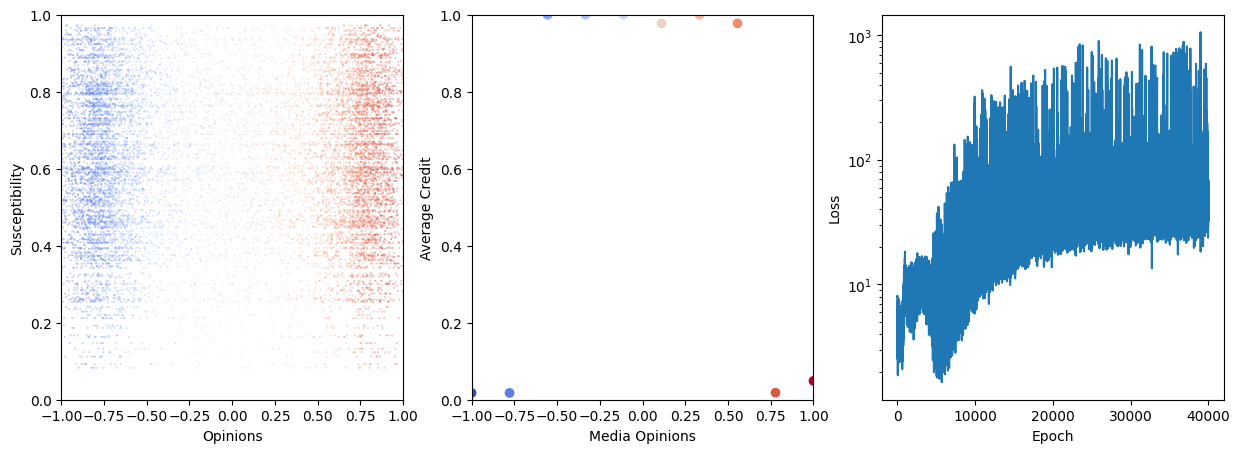

Epoch: 40000, Loss: 3.1e+01, Normalized Loss: 3.6e-02, Count: 2000050, Reward: 3.8e-01
Average Media Credits: [0.01758802 0.01758802 1.         1.         1.         0.9775676
 1.         0.9775676  0.01826863 0.04897328]


In [ ]:
# Set parameters
N = 500  # Number of agents
M = 10   # Number of media sources
terminal_time = 200
duration = 1  # Duration per action
nbins = 30
scale = 100
gamma = 0.95
learning_rate = 1e-4
batch_size = 64
update_freq = batch_size * 1
capacity = 1 * 10**5
episodes = 2000000
observation_dim = nbins + M
beta_policy = 10  # Inverse temperature for policy
beta_opponent = -10  # Inverse temperature for opponent
tau = 0.002
action_dimension = 2 ** int(M / 2)
# Initialize environment
env = OpinionWithMedia(N=N, M=M, terminal_time=terminal_time, bM=5, b=20, noise_level=0.1,
                       duration=duration, h=0.1, nbins=nbins, r_scale=scale)
env.reset()
# Initialize networks
target_net = SoftQNetwork(observation_dim, beta_policy, beta_opponent, M, action_dimension)
eval_net = SoftQNetwork(observation_dim, beta_policy, beta_opponent, M, action_dimension)
avg_net = SoftQNetwork(observation_dim, beta_policy, beta_opponent, M, action_dimension)
eval_net.load_state_dict(target_net.state_dict())
# Optimizer and loss function
optimizer = torch.optim.Adam(eval_net.parameters(), lr=learning_rate, weight_decay=1e-3)
loss_fn = nn.MSELoss()
buffer = ReplayBuffer(capacity)
count = 0
reward_total = []
Loss = []
epoch = 0

# Initialize variables for plotting and logging
C_list = []  # List to store media credits
X_list = []  # List to store agents' opinions
Loss_list = []  # List to store losses

# Training loop
for episode_num in range(episodes):
    # Reset environment and get initial observation
    state = env.reset()
    observation = env.state2obs(state)
    done = False

    while not done:
        # Select actions using the evaluation network
        u_action_id, v_action_id, action_id, action_dist = eval_net.act(torch.FloatTensor(np.expand_dims(observation, 0)))

        # Take a step in the environment
        next_state, reward, done, _ = env.step(u_action_id, v_action_id)
        x, c, t = next_state[:N], next_state[N:-1], next_state[-1]
        next_observation = env.state2obs(next_state)

        # Store experience in replay buffer
        buffer.store(observation, action_id, reward, next_observation, done)
        reward_total.append(reward)
        observation = next_observation

        # Update networks if enough experiences are available
        if len(buffer) > batch_size and count % 50 == 0:
            epoch += 1
            loss_p, loss_n, q_values = train(buffer, target_net, eval_net, gamma, optimizer, batch_size, loss_fn, count, update_freq, tau)
            Loss_list.append(loss_p)

            # Update average network for evaluation
            for key in eval_net.state_dict():
                avg_net.state_dict()[key] = eval_net.state_dict()[key] / 100 + avg_net.state_dict()[key]

            # Periodically display progress
            if epoch % 100 == 0:
                # Plotting
                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                # Plot agents' opinions over time
                ax[0].scatter(x=np.array(X_list).flatten(), y=np.repeat(env.s.numpy(), len(X_list)), c=np.array(X_list).flatten(), s=0.1, cmap='coolwarm', alpha=0.5)
                ax[0].set_ylim(0, 1)
                ax[0].set_xlim(-1, 1)
                ax[0].set_xlabel('Opinions')
                ax[0].set_ylabel('Susceptibility')
                # Plot average media credits
                ax[1].scatter(x=np.linspace(-1, 1, env.M), y=np.array(C_list).mean(axis=0), c=np.linspace(-1, 1, env.M), cmap='coolwarm')
                ax[1].set_ylim(0, 1)
                ax[1].set_xlim(-1, 1)
                ax[1].set_xlabel('Media Opinions')
                ax[1].set_ylabel('Average Credit')
                # Plot loss over time
                ax[2].semilogy(Loss_list)
                ax[2].set_xlabel('Epoch')
                ax[2].set_ylabel('Loss')

                # Display plots
                clear_output(wait=True)
                display(plt.gcf())
                plt.close(fig)

                # Print progress
                print(f'Epoch: {epoch}, Loss: {np.mean(Loss_list):.1e}, Normalized Loss: {loss_n:.1e}, Count: {count}, Reward: {np.mean(reward_total):.1e}')
                print(f'Average Media Credits: {np.mean(np.array(C_list), axis=0)}')

                # Reset logging variables
                reward_total = []
                C_list = []
                X_list = []
                # Loss_list = []

        count += 1

        if done:
            # Store final media credits and agents' opinions
            C_list.append(c.numpy())
            X_list.append(x.numpy())
            break

    # Terminate training if maximum epoch is reached
    if epoch >= 40000:
        break




## Test and display

In [ ]:
# Test the trained network
test_net = SoftQNetwork(observation_dim, beta_policy, beta_opponent, M, action_dimension)
test_net.load_state_dict(target_net.state_dict())

c_mean = torch.zeros(M)
x_list = []
repetitions = 30
R_mean = 0

for _ in range(repetitions):
    total_reward = 0
    state = env.reset()
    done = False

    while not done:
        # Get observation
        observation = env.state2obs(state)

        # Select actions using the test network
        u_action_id, v_action_id, action_id, _ = test_net.act(torch.FloatTensor(np.expand_dims(observation, 0)))

        # Take a step in the environment
        next_state, reward, done, _ = env.step(u_action_id, v_action_id)
        x, c, t = next_state[:N], next_state[N:-1], next_state[-1]
        total_reward += reward / env.terminal_time
        state = next_state

        if done:
            c_mean += c / repetitions
            x_list.append(x.numpy())
            R_mean += total_reward / repetitions
            break

print(f'Number of episodes: {repetitions}, Mean reward: {R_mean:.3f}')

# Plot results
env.plot_dist(torch.tensor(x_list[-1]), c_mean)
plt.hist(np.concatenate(x_list), bins=np.linspace(-1, 1, 200), density=True)
plt.show()